# TD2: Spatial Discretization with Spectral Methods I

When facing a spatial differential equation that we want to solve numerically, with spatial discretization methods we want to compute all values $f(x_0), ..., f(x_N)$ of a discretized function $f$ simultaneously. Spatial discretization methods are therefore opposed to temporal discretization methods for which the computation of $f(t_{i+1})$ relies on the previous values $f(t_0),..., f(t_i)$.

In this TD we will not be interested yet in solving a spatial differential equation as we first need to get familiar with methods to approximate a function $f$, and we will focus here on **spectral methods**. We recall that spectral methods rely on the expansion of a function $f$ on a basis of functions $\{\phi_k\}_k$ (in a function space we do not specify at this point). The coefficients of the expansion will be noted $\hat{f}_k$. Thus we have:
$$
    f(x) = \sum_{k}\hat{f}_k\phi_k(x)
$$

The choice of the basis $\{\phi_k\}_k$ is obviously crucial for the efficiency of a numerical calculation. We will make sure for a practical case that the chosen basis meets the following requirements:
* **Convergence:** the series should converge rapidly enough to the function $f$
* **Transformation:** the computation of the coefficients $\hat{f}_k$ should be numerically fast, as well as the inverse transformation
* **Differentiation:** it should be easy to compute the derivative of $f$ through its expansion, meaning we can determine $\widehat{f^\prime}_k$ easily

As usual, we will need the following packages:

In [1]:
# To draw matplotlib plots within this notebook.
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

## Part 1: Fourier interpolation

In spectral methods, given a set of points $\{x_k\}_k$ we define the interpolant $\mathbb{I}_N[f]$ of a function $f$ based on the series representation of $f$ on the basis $\{\phi_k\}_k$. Thus, we approximate $f$ by a truncated series:
$$
    \mathbb{I}_N[f] = \sum_{k = 0}^{N}\hat{f}_k\phi_k
$$
(depending on the chosen basis, we can have slightly different definitions of $\mathbb{I}_N[f]$). This function in an interpolation of $f$, and should therefore satisfy $\forall k, f(x_k) = \mathbb{I}_N[f](x_k)$.

### Fourier basis

In this TD we only consider a Fourier basis $\phi_k(x) = e^{i k x}$ in the function space $L^2([0,2\pi])$. We choose the spatial domain $[0, 2\pi]$ for convenience in the expression of the following formula, but any scaling would make the following transposable to any compact domain $[a,b]$. We also define a set of $N$ regularly spaced points in this domain $\{x_m = \frac{2\pi m}{N}, m = 0, ..., N - 1\}$. Now for a function $f$, we define its approximation by the interpolant:
$$
    \mathbb{I}_N[f](x) = \sum_{k = \left \lfloor{-N/2}\right \rfloor + 1}^{\left \lfloor{N/2}\right \rfloor}{\hat{f}_k e^{ikx}}
$$
Note that this function is a continuous function, therefore it can be evaluated at any point in $[0,2\pi]$. The determination of the interpolant is directly related to the FFT such as defined in the [*numpy* implementation](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.fft.html): the coefficients $\hat{f}_k$ are those computed by *np.fft.fft (fVals) / N* where *fVals* is the vector of values of the set $\{f(x_m)\}_m$ and $N$ the length of *fVals*. We will pay attention to the order of the coefficients returned by *np.fft.fft* function. We also recall that the FFT algorithm has a $\mathcal{O}(N\log(N))$ complexity.

**1)** Write a function which computes from a given set of values $\{f(x_m)\}_m$ the interpolant coefficients $\{\hat{f}_k\}_k$. Complexity should be a $\mathcal{O}(N\log(N))$.

In [2]:
def customFFT(x):
    temp = np.fft.fft(x)
    return temp / len(temp)

**2)** Write a function which computes from an arbitrary set of points and for a given set of coefficients $\{\hat{f}_k\}_k$ the values of $\mathbb{I}_N[f]$ evaluated at the input points. We will not care about the complexity of the algorithm.

In [3]:
def customIFFT(x, coeff):
    import math
    result = np.zeros(len(x), dtype = 'complex64')
    for i in range(math.floor(len(coeff)/2)):
        result += coeff[i] * np.exp(1j*i*x)
    for i in range(math.floor(-len(coeff)/2)+1,0):
        result += coeff[i] * np.exp(1j*i*x)        
    return result

**3)** Is $\mathbb{I}_N[f]$ always a real function?

We will use and assume an **odd value of $N$** in the following.

**4)** Compare by plotting on $[0,2\pi]$ in the following cases the exact function with its interpolant for several values of $N$:
* $f(x) = \cos(x) + \sin(2x)$
* $  f(x) = \begin{cases}
    \frac{\pi}{4} & \text{if } 0 \leq x < \pi \\
    -\frac{\pi}{4} & \text{if } \pi \leq x < 2\pi
  \end{cases}$
* $ f(x) = \sin (2x)\exp\left(\cos\left(8x\right)\right)$
  
Can you observe the Gibbs phenomenon for one of these functions?

C:\Users\emanu\AppData\Local\Programs\Python\Python37-32\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


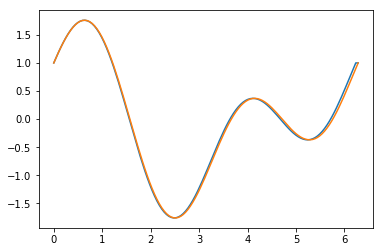

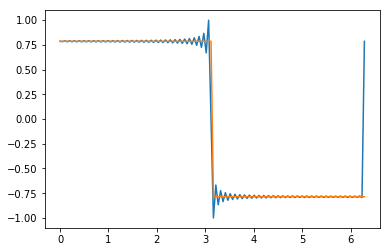

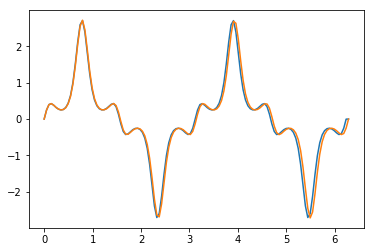

In [4]:
def f1(x):
    return np.cos(x)+np.sin(2*x)
    
def f2(x):
    temp = x.copy()
    temp[x < np.pi] = np.pi/4
    temp[x >= np.pi] = -np.pi/4
    return temp

def f3(x):
    return np.sin(2*x)*np.exp(np.cos(8*x))

def FourierTest(function, N):
    x = np.linspace(0,2*np.pi,N)

    y = function(x)
    coeff = customFFT(y)
    y1 = customIFFT(x,coeff)
    
    plt.plot(x,y1)
    plt.plot(x,y)
    plt.show()

Ntest = 128
FourierTest(f1,Ntest)
FourierTest(f2,Ntest)
FourierTest(f3,Ntest)

## Part 2: Spectral differentiation with Fourier representation

Spectral representations will be useful to solve a differential equation only if we can easily differentiate them. In this part, we will see how we can do that within a Fourier representation of a given function $f$.

### Fourier representation

Using the same notations as before, we already defined an interpolant $\mathbb{I}_N[f]$ which approximates $f$. It is easy to differentiate $\mathbb{I}_N[f]$:
$$
    \mathbb{I}_N[f]^\prime(x)= \sum_{k = \left \lfloor{-N/2}\right \rfloor + 1}^{\left \lfloor{N/2}\right \rfloor}{ik\hat{f}_k e^{ikx}}
$$
Now we can wonder if this function is still a good approximation of $f^\prime$.

**1)** Write a function which computes the coefficients of $\mathbb{I}_N[f]^\prime$ given the set of $\{\hat{f}_k\}_k$.

In [5]:
def derivative(coeff):
    import math
    for i in range(math.floor(len(coeff)/2)):
        coeff[i] *= i * 1j
    for i in range(math.floor(-len(coeff)/2)+1,0):
        coeff[i] *= i * 1j
    return coeff

**2)** Using *np.fft.ifft* function ($\mathcal{O}(N\log(N))$ complexity), write a function which computes the values $\{\mathbb{I}_N[f]^\prime(x_m)\}_m$ given the coefficients of $\mathbb{I}_N[f]^\prime$. Complexity of the algorithm should be a $\mathcal{O}(N\log(N))$.

In [6]:
def customNewIFFT(coeff):
    coeff *= len(coeff)
    return np.fft.ifft(coeff)

**3)** Compare by plotting the exact value of $f^\prime$ and the approximation $\mathbb{I}_N[f]^\prime$ in the following cases:
* $f(x) = \cos(x) + \sin(2x)$
* $  f(x) = \begin{cases}
    \frac{\pi}{4} & \text{if } 0 \leq x < \pi \\
    -\frac{\pi}{4} & \text{if } \pi \leq x < 2\pi
  \end{cases}$
* $ f(x) = \sin (2x)\exp\left(\cos\left(8x\right)\right)$

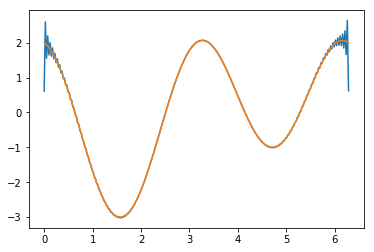

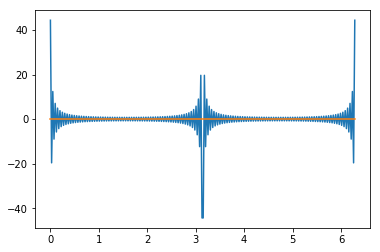

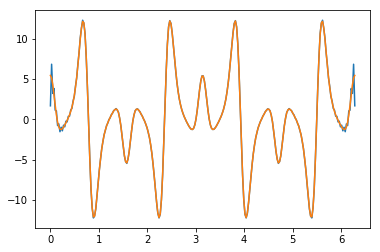

In [7]:
def g1(x):
    return -np.sin(x)+2*np.cos(2*x)
    
def g2(x):
    temp = np.zeros(len(x))
    return temp

def g3(x):
    return 2*np.exp(np.cos(8*x))*(np.cos(2*x)-4*np.sin(2*x)*np.sin(8*x))

def FourierDerTest(function, functionDer, N):
    x = np.linspace(0,2*np.pi,N)

    yDer = functionDer(x)
    y = function(x)
    coeff = customFFT(y)
    coeffDer = derivative(coeff)
    y1 = customNewIFFT(coeffDer)

    plt.plot(x,y1)
    plt.plot(x,yDer)
    plt.show()

FourierDerTest(f1,g1,256)
FourierDerTest(f2,g2,256)
FourierDerTest(f3,g3,256)

Note that we have been dealing so far with Fourier interpolation and Fourier differentiation only for odd values of N. Indeed, it is easier to define a real interpolant when symmetric modes are involved.

Dealing with even values of $N$ can be more technical, curious readers could take a look at [Steven G. Johnson notes](https://math.mit.edu/~stevenj/fft-deriv.pdf) to get a deeper understanding of what is behind the definition of a Fourier interpolant.

## Part 3: Aliasing around an example...

Aliasing effects are caused by the fact that on a discrete grid $\{x_m = \frac{2\pi m}{N}, m = 0, ..., N - 1\}$, all modes $\{\phi_{k + jN}(x) = e^{i(k+jN)x}\}_{j\in\mathbb{Z}}$ are indistinguishable (they are *aliases* of one another). Let us see on an example what it can look like...

Let us consider the following functions of $L^2([0,2\pi])$:
* $u(x) = \cos (2x)$
* $v(x) = \sin (x)$
* $w (x) = u (x)\times v (x) = \cos (2x) \sin (x)$

**1)** What is the Fourier series associated with $w$? What is the minimum odd value of $N$ so that $\mathbb{I}_N[w] = w$?

**1A)** Just notice that $w(x) = 1/2(sin(3x)-sin(x))$



**2)** Compute $\mathbb{I}_N[w]$ and then plot $u, v, w$ and their interpolants $\mathbb{I}_N[u], \mathbb{I}_N[v], \mathbb{I}_N[w]$ on the same figures for $N = 7$, $N = 5$ and $N = 3$. Discuss what you observe.

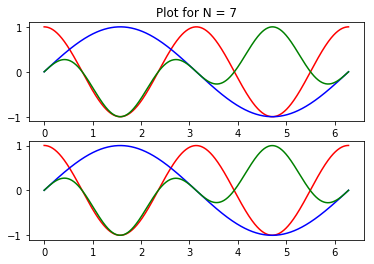

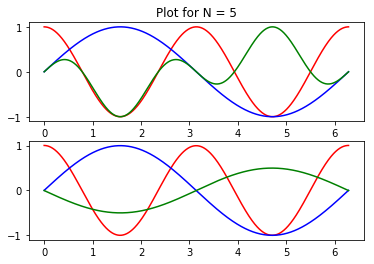

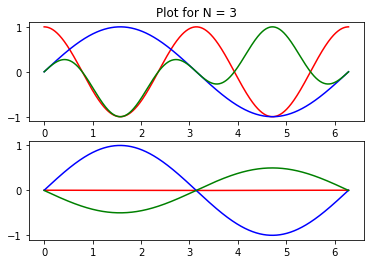

In [8]:
def u(x):
    return np.cos(2*x)

def v(x):
    return np.sin(x)

def w(x):
    return np.cos(2*x)*np.sin(x)

def customNIFFT(x, coeff, N):
    import math
    N += 1
    result = np.zeros(len(x), dtype = 'complex64')
    for i in range(N):
        result += coeff[i] * np.exp(1j*i*x)
    for i in range(-N+1,0):
        result += coeff[i] * np.exp(1j*i*x)        
    return result

def FourierCalc(function, N, NFourier):
    x = np.linspace(0,2*np.pi,N)

    y = function(x)
    coeff = customFFT(y)
    y1 = customNIFFT(x,coeff,NFourier)
    return x, y, y1

def Aliasing(N, NFourier):
    x, yu, yu1 = FourierCalc(u,N,NFourier)
    x, yv, yv1 = FourierCalc(v,N,NFourier)
    x, yw, yw1 = FourierCalc(w,N,NFourier)

    plt.subplot(2,1,1)
    plt.title('Plot for N = {}'.format(NFourier*2+1))
    plt.plot(x,yu, color = 'red')
    plt.plot(x,yv, color = 'blue')
    plt.plot(x,yw, color = 'green')
    plt.subplot(2,1,2)
    plt.plot(x,yu1, color = 'red')
    plt.plot(x,yv1, color = 'blue')
    plt.plot(x,yw1, color = 'green')
    plt.show()
    
Aliasing(1000,3)
Aliasing(1000,2)
Aliasing(1000,1)

**3)** Generally with spectral methods it is easier to compute products in physical space to avoid some convolutions in spectral space. In this case we talk about **pseudo-spectral methods**. On a numerical problem, what should we do generally before and after computing products $u \times v$ in physical space?

**BONUS: 4)** Propose a *de-aliasing* algorithm that computes $\hat{w}_k$ coefficients given the sets of $\hat{u}_k$ and $\hat{v}_k$ coefficients and which avoids unwanted aliasing effects.

In [9]:
def product(u, v):
    x = np.linspace(0,2*np.pi,N)
    yu = customIFFT(x,u)
    yv = customIFFT(x,v)
    return customFFT(yu * yv)